In [1]:
from VAE import VAE
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
from torchvision.datasets import CelebA
import matplotlib.pyplot as plt
import einops
from tqdm import tqdm
import math
from utils import display_img

In [2]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class MyCelebADataset(Dataset):
    def __init__(self, images_dir, attributes_file, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        
        # Read the attributes file
        with open(attributes_file, "r") as f:
            lines = f.readlines()
        
        self.attr_names = lines[1].strip().split()  # list of attribute names
        self.data = []
        for line in lines[2:]:  # skip first two lines
            parts = line.strip().split()
            filename = parts[0]
            attrs = list(map(int, parts[1:]))
            self.data.append((filename, attrs))
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        filename, attrs = self.data[idx]
        img_path = os.path.join(self.images_dir, filename)
        image = Image.open(img_path)
        
        if self.transform:
            image = self.transform(image)
        
        attrs = torch.tensor(attrs, dtype=torch.float32)
        
        return image, attrs

In [3]:
transform = transforms.Compose([
    transforms.CenterCrop(178),     # Crop to 178x178 (centered)
    transforms.Resize(64),          # Then resize to 64x64
    transforms.ToTensor(),          # Convert to tensor (scales pixel values to [0,1])
])

dataset = MyCelebADataset(
    images_dir="/Users/spra/Desktop/Personal Projects/CelebA/celeba/img_align_celeba",
    attributes_file="/Users/spra/Desktop/Personal Projects/CelebA/celeba/list_attr_celeba.txt",
    transform=transform
)

dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

In [4]:
model = VAE(device = 'mps', in_channels = 3, latent_dim = 128)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [5]:
def train(loader, model, optimizer):
    model = model.to(model.device)
    losses = []
    for batch in tqdm(loader):
        images, atributes = batch[0], batch[1]
        images = images.to(model.device)
        reconstructions, mu, logvar = model(images)
        loss = model.loss_function(images, reconstructions, mu, logvar)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(loss.item())
    print(f'Average loss: {sum(losses)/len(losses)}')
    return losses

In [6]:
num_epochs = 20
all_losses = []
for i in range(num_epochs):
    print(f'Starting epoch: {i}')
    losses = train(dataloader, model, optimizer)
    all_losses.extend(losses)

Starting epoch: 0


100%|██████████| 1583/1583 [02:18<00:00, 11.43it/s]


Average loss: 0.039028434295840304
Starting epoch: 1


100%|██████████| 1583/1583 [02:29<00:00, 10.62it/s]


Average loss: 0.03322416407115574
Starting epoch: 2


100%|██████████| 1583/1583 [02:44<00:00,  9.61it/s]


Average loss: 0.03261568303033474
Starting epoch: 3


100%|██████████| 1583/1583 [02:49<00:00,  9.33it/s]


Average loss: 0.032344923325857255
Starting epoch: 4


100%|██████████| 1583/1583 [02:36<00:00, 10.09it/s]


Average loss: 0.032162606340803
Starting epoch: 5


100%|██████████| 1583/1583 [03:49<00:00,  6.88it/s] 


Average loss: 0.0320179386597435
Starting epoch: 6


100%|██████████| 1583/1583 [02:18<00:00, 11.43it/s]


Average loss: 0.031925080046387166
Starting epoch: 7


100%|██████████| 1583/1583 [02:18<00:00, 11.45it/s]


Average loss: 0.03185145630350011
Starting epoch: 8


100%|██████████| 1583/1583 [02:17<00:00, 11.49it/s]


Average loss: 0.031791633500971146
Starting epoch: 9


100%|██████████| 1583/1583 [02:16<00:00, 11.60it/s]


Average loss: 0.03174084078094587
Starting epoch: 10


100%|██████████| 1583/1583 [02:16<00:00, 11.58it/s]


Average loss: 0.03170165946720073
Starting epoch: 11


100%|██████████| 1583/1583 [02:21<00:00, 11.20it/s]


Average loss: 0.031674187058560545
Starting epoch: 12


100%|██████████| 1583/1583 [02:17<00:00, 11.53it/s]


Average loss: 0.03164030132263391
Starting epoch: 13


100%|██████████| 1583/1583 [02:19<00:00, 11.34it/s]


Average loss: 0.03161144018083792
Starting epoch: 14


100%|██████████| 1583/1583 [02:23<00:00, 11.02it/s]


Average loss: 0.03159443122544811
Starting epoch: 15


100%|██████████| 1583/1583 [02:25<00:00, 10.92it/s]


Average loss: 0.031565079740845776
Starting epoch: 16


100%|██████████| 1583/1583 [02:20<00:00, 11.31it/s]


Average loss: 0.031545009900564566
Starting epoch: 17


100%|██████████| 1583/1583 [02:19<00:00, 11.34it/s]


Average loss: 0.03152710797802903
Starting epoch: 18


100%|██████████| 1583/1583 [02:21<00:00, 11.16it/s]


Average loss: 0.03151829723699403
Starting epoch: 19


100%|██████████| 1583/1583 [02:21<00:00, 11.21it/s]

Average loss: 0.03148932180668046


In [7]:
torch.save(model.state_dict(), 'ten_epochs.pt')

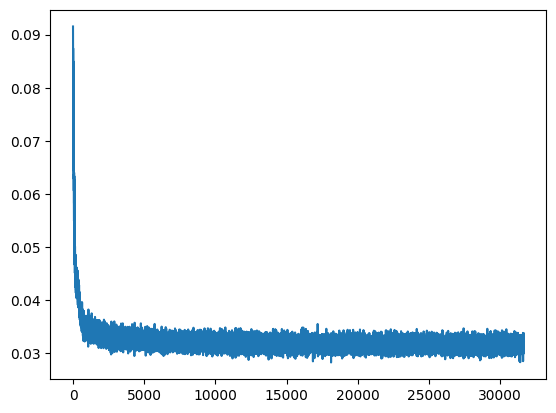

In [8]:
plt.plot(all_losses)

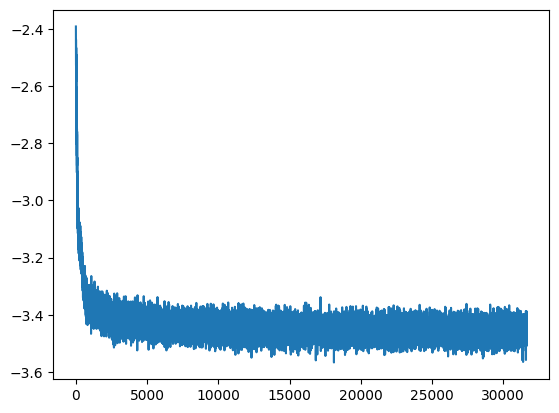

In [9]:
log_losses = torch.log(torch.tensor(all_losses)).cpu().numpy()
plt.plot(log_losses)

In [10]:
def display_img(img, h, w):
    reshaped = einops.rearrange(img, 'b c h w -> b h w c').cpu().numpy()
    fig, ax = plt.subplots(h, w, figsize=(10, 10))
    for i in range(h):
        for j in range(w):
            to_show = reshaped[h * i + j]
            ax[i, j].imshow(to_show)
            ax[i, j].axis('off')

In [18]:
batch = next(iter(dataloader))

In [19]:
def reconstruct(model, batch):
    batch = batch[0].to(model.device)
    with torch.no_grad():
        reconstructions, mu, logvar = model(batch)
    return reconstructions

In [20]:
reconstructions = reconstruct(model, batch)

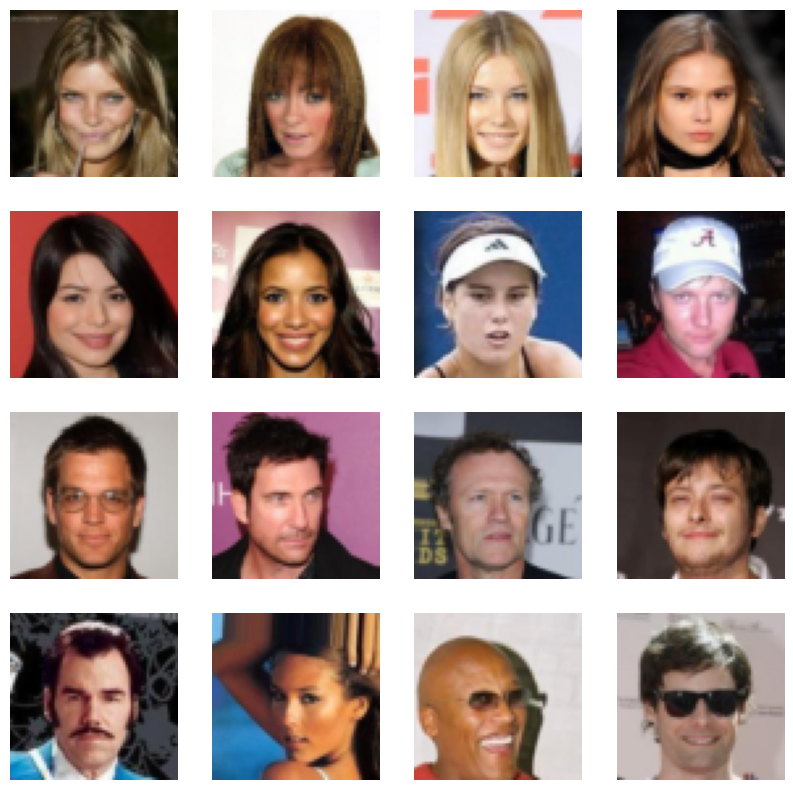

In [21]:
display_img(batch[0], 4, 4)

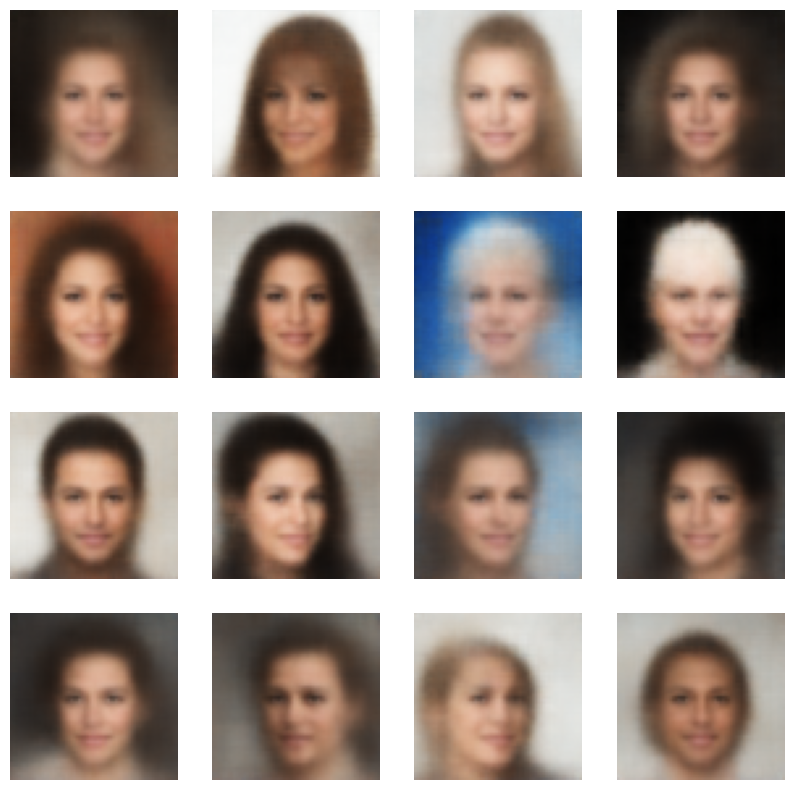

In [22]:
display_img(reconstructions, 4, 4)